#### **INSTALL NECESSARY LIBRARIES**

In [2]:
%%capture
!pip install plotly
!pip install pytorch_toolbelt # for easy patch-based prediction
!pip install albumentations # for data augmentation
!pip install torchsummary # for pytorch model architecture summar

#### IMPORT LIBRARIES

In [3]:
# deep learining modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A


from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
import numpy as np

#image preparation module
import cv2

#data visualization modules
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd

#### **Read in dataset**

In [7]:
dir = 'Parihaka_Seismic_Facies_Challenge/'

images = np.fromfile(dir+'Image_train_1006_777_590.bin', dtype = '>f4')#.newbyteorder('>')
labels = np.fromfile(dir+'Labels_train_1006_777_590.bin', dtype = 'float32').newbyteorder('>')

In [8]:
# Ensure that dataset is from 0-5 instead of 1-6
labels -= 1

In [9]:
# check statistic of dataset
images.min(), images.max(), labels.min(), labels.max()

(-5195.5234, 5151.7188, 0.0, 5.0)

In [10]:
# check shape of datset
images.shape, labels.shape

((461180580,), (461180580,))

In [12]:
# Resize
images = images.reshape(590, 777, 1006).transpose(2, 1, 0)
labels = labels.reshape(590, 777, 1006).transpose(2, 1, 0)
images.shape, labels.shape

((1006, 777, 590), (1006, 777, 590))

#### **Split into training and testing set**

In [15]:
train_images = images[:,:, :472]
train_labels = labels[:,:, :472]

test_images = images[:,:,472:]
test_labels = labels[:,:,472:]

train_images.shape, test_images.shape

((1006, 777, 472), (1006, 777, 118))

In [16]:
# Pick diagonal slice
def ax(arr):
    ax1, ax2 = np.diagonal(arr).T, np.fliplr(arr).diagonal().T
    ax3, ax4 = np.diagonal(arr, 0,0,-1).T, np.flipud(arr).diagonal(0,0,-1).T
    
    arr2 = arr[:,:,[i for i in range(0,arr.shape[2])]] = arr[:,:,[i for i in range(arr.shape[2]-1, -1, -1)]]
    
    ax5, ax6 = np.diagonal(arr2).T, np.fliplr(arr2).diagonal().T
    ax7, ax8 = np.diagonal(arr2, 0,0,-1).T, np.flipud(arr2).diagonal(0,0,-1).T
    return ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8

In [1]:
# Create 3d slices from which diagonal slices will be extracted
def test_diag(img,lab, ps, amount):
    if amount % 8 == 0:
        data_test_p = np.zeros([ps,ps,amount*8],dtype='float32')
        label_test_p = np.zeros([ps,ps,amount*8],dtype='float32')
        b = np.random.randint(low = [0,0,0], high = (np.array(img.shape)-ps).tolist(), size = (amount,3))
        for i,row in enumerate(b):
            h,x,y = row[0], row[1], row[2] 
            a = img[h:h+ps,x:x+ps,y:y+ps]
            a_lab = lab[h:h+ps,x:x+ps,y:y+ps]
            ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = ax(a)
            ax1_, ax2_, ax3_, ax4_, ax5_, ax6_, ax7_, ax8_ = ax(a_lab)
            data_test_p[:,:, i*8:i*8+8] = np.dstack((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8))
            label_test_p[:,:, i*8:i*8+8] = np.dstack((ax1_, ax2_, ax3_, ax4_, ax5_, ax6_, ax7_, ax8_))
        return data_test_p, label_test_p

In [18]:
# Slice dataset through Y plane
def test_crop_x(test_images,test_labels, ps):
    lx = int(np.ceil(test_images.shape[0]/ps)*np.ceil(test_images.shape[2]/ps)*test_images.shape[1]) 
    data_test_p = np.zeros([ps,ps,lx],dtype='float32')
    label_test_p = np.zeros([ps,ps,lx],dtype='float32')

    xx = 0
    for x in range(test_images.shape[1]):
        for i in range(int(np.ceil(test_images.shape[0]/ps))):
            for j in range(int(np.ceil(test_images.shape[2]/ps))):
                if i==int(np.ceil(test_images.shape[0]/ps))-1 and j==int(np.ceil(test_images.shape[2]/ps))-1:
                    data_test_p[:,:,xx] = test_images[test_images.shape[0]-ps:,x, test_images.shape[2]-ps:]
                    label_test_p[:,:,xx] = test_labels[test_images.shape[0]-ps:,x, test_images.shape[2]-ps:]      
                elif i==int(np.ceil(test_images.shape[0]/ps))-1:
                    data_test_p[:,:,xx] = test_images[test_images.shape[0]-ps:,x, j*ps:j*ps+ps]
                    label_test_p[:,:,xx] = test_labels[test_images.shape[0]-ps:,x,j*ps:j*ps+ps]
                elif j==int(np.ceil(test_images.shape[2]/ps))-1: 
                    data_test_p[:,:,xx] = test_images[i*ps:i*ps+ps,x,test_images.shape[2]-ps:]
                    label_test_p[:,:,xx] = test_labels[i*ps:i*ps+ps,x,test_images.shape[2]-ps:]
                else:
                    data_test_p[:,:,xx] = test_images[i*ps:i*ps+ps,x,j*ps:j*ps+ps]
                    label_test_p[:,:,xx] = test_labels[i*ps:i*ps+ps,x,j*ps:j*ps+ps]
                xx=xx+1
    return data_test_p, label_test_p

In [19]:
# Slice dataset through Z plane
def test_crop_y(test_images,test_labels, ps):
    lx = int(np.ceil(test_images.shape[0]/ps)*np.ceil(test_images.shape[1]/ps)*test_images.shape[2]) 
    data_test_p = np.zeros([ps,ps,lx],dtype='float32')
    label_test_p = np.zeros([ps,ps,lx],dtype='float32')

    xx = 0
    for x in range(test_images.shape[2]):
        for i in range(int(np.ceil(test_images.shape[0]/ps))):
            for j in range(int(np.ceil(test_images.shape[1]/ps))):
                if i==int(np.ceil(test_images.shape[0]/ps))-1 and j==int(np.ceil(test_images.shape[1]/ps))-1:
                    data_test_p[:,:,xx] = test_images[test_images.shape[0]-ps:,test_images.shape[1]-ps:,x]
                    label_test_p[:,:,xx] = test_labels[test_images.shape[0]-ps:,test_images.shape[1]-ps:,x]      
                elif i==int(np.ceil(test_images.shape[0]/ps))-1:
                    data_test_p[:,:,xx] = test_images[test_images.shape[0]-ps:,j*ps:j*ps+ps,x]
                    label_test_p[:,:,xx] = test_labels[test_images.shape[0]-ps:,j*ps:j*ps+ps,x]
                elif j==int(np.ceil(test_images.shape[1]/ps))-1: 
                    data_test_p[:,:,xx] = test_images[i*ps:i*ps+ps,test_images.shape[1]-ps:,x]
                    label_test_p[:,:,xx] = test_labels[i*ps:i*ps+ps,test_images.shape[1]-ps:,x]
                else:
                    data_test_p[:,:,xx] = test_images[i*ps:i*ps+ps,j*ps:j*ps+ps,x]
                    label_test_p[:,:,xx] = test_labels[i*ps:i*ps+ps,j*ps:j*ps+ps,x]
                xx=xx+1
    return data_test_p, label_test_p

In [20]:
# Execute slicing for training dataset
train_images1, train_labels1 = test_crop_x(train_images, train_labels, 256)
train_images2, train_labels2 = test_crop_y(train_images, train_labels, 256)
train_images3, train_labels3 = test_diag(train_images, train_labels, 256, 48)

In [21]:
# Combine different 2D slice directions to form one combination of training slices
train_images = np.dstack((train_images1, train_images2, train_images3))
train_labels = np.dstack((train_labels1, train_labels2, train_labels3))

In [22]:
train_images.shape, train_labels.shape

((256, 256, 14152), (256, 256, 14152))

In [23]:
class seisdataset_train(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X.astype('float32')
        self.y = y.astype('float32')
        self.aug = A.Compose([             
            A.ShiftScaleRotate(p=0.35, shift_limit=0, scale_limit=0.30, rotate_limit=30) ,                 
            A.HorizontalFlip(p=0.5),                  
#             A.RandomCrop(p=1, height=256, width=256),
        ])

    def __len__(self):
        return self.X.shape[2]
    
    def __getitem__(self,index):
        data = self.X[:,:,index]
        label = self.y[:,:,index]
        data_aug = self.aug(image=data, mask=label)
        data, label = data_aug['image'], data_aug['mask']          
        return data[None,:,:], label

In [24]:
# Execute Pytorch Data Reader
train_data = seisdataset_train(train_images, train_labels)

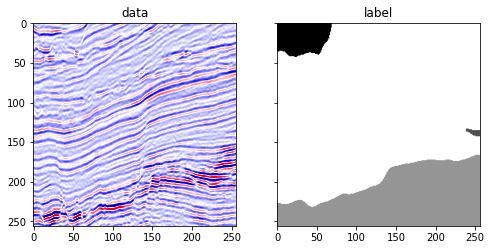

In [25]:
no_sample = 50
data_get = train_data[no_sample]
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,8))
ax[0].imshow(data_get[0][0,:,:], cmap='seismic')
ax[1].imshow(data_get[1], cmap='Greys')
ax[0].set_title('data')
ax[1].set_title('label')
plt.show()

In [26]:
# ps = 256 #patch size
# lx = int(np.ceil(test_images.shape[0]/ps)*np.ceil(test_images.shape[1]/ps)*test_images.shape[2]) 
# data_test_p = np.zeros([ps,ps,lx],dtype='float32')
# label_test_p = np.zeros([ps,ps,lx],dtype='float32')


In [27]:
#Slice validation set through Z plane
def test_crop_test(test_images,test_labels, ps):
    lx = int(np.ceil(test_images.shape[0]/ps)*np.ceil(test_images.shape[1]/ps)*test_images.shape[2]) 
    data_test_p = np.zeros([ps,ps,lx],dtype='float32')
    label_test_p = np.zeros([ps,ps,lx],dtype='float32')

    xx = 0
    for x in range(test_images.shape[2]):
        for i in range(int(np.ceil(test_images.shape[0]/ps))):
            for j in range(int(np.ceil(test_images.shape[1]/ps))):
                if i==int(np.ceil(test_images.shape[0]/ps))-1 and j==int(np.ceil(test_images.shape[1]/ps))-1:
                    data_test_p[:,:,xx] = test_images[test_images.shape[0]-ps:,test_images.shape[1]-ps:,x]
                    label_test_p[:,:,xx] = test_labels[test_images.shape[0]-ps:,test_images.shape[1]-ps:,x]      
                elif i==int(np.ceil(test_images.shape[0]/ps))-1:
                    data_test_p[:,:,xx] = test_images[test_images.shape[0]-ps:,j*ps:j*ps+ps,x]
                    label_test_p[:,:,xx] = test_labels[test_images.shape[0]-ps:,j*ps:j*ps+ps,x]
                elif j==int(np.ceil(test_images.shape[1]/ps))-1: 
                    data_test_p[:,:,xx] = test_images[i*ps:i*ps+ps,test_images.shape[1]-ps:,x]
                    label_test_p[:,:,xx] = test_labels[i*ps:i*ps+ps,test_images.shape[1]-ps:,x]
                else:
                    data_test_p[:,:,xx] = test_images[i*ps:i*ps+ps,j*ps:j*ps+ps,x]
                    label_test_p[:,:,xx] = test_labels[i*ps:i*ps+ps,j*ps:j*ps+ps,x]
                xx=xx+1
    return data_test_p, label_test_p
test_images, test_labels = test_crop_test(test_images, test_labels, 256)

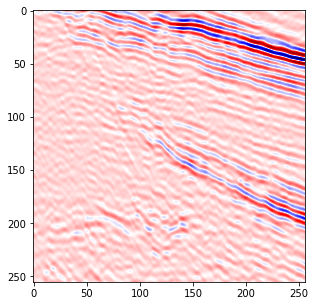

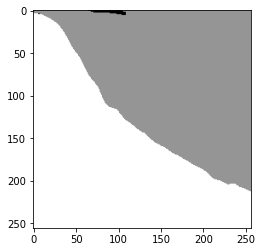

In [28]:
inline=30
fig = plt.figure(figsize=(5,5))
plt.imshow(test_images[:,:,inline], cmap='seismic')
plt.show()
plt.imshow(test_labels[:,:,inline],cmap='Greys')
plt.show()

In [29]:
test_images.shape, test_labels.shape # shape of validation set

((256, 256, 1888), (256, 256, 1888))

In [30]:
# Load validation data
class seisdataset_test(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X.astype('float32')
        self.y = y.astype('float32')

    def __len__(self):
        return self.X.shape[2]

    def __getitem__(self,index):
        data = self.X[:,:,index]
        label = self.y[:,:,index]
        return data[None,:,:], label

In [31]:
batch_size =  32  #training batch size
num_epochs = 15    #number of epochs to train
num_classes = 6    #number of facies classes
learning_rate = 0.001 #learning rate

In [32]:
def get_data_loaders(batch_size):
    train_data = seisdataset_train(train_images, train_labels)
    test_data = seisdataset_test(test_images, test_labels)
    
    train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader


In [33]:
!nvidia-smi #check compute resources

Tue Apr  6 00:16:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   36C    P0    44W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #CPU/GPU selection
train_loader,test_loader=get_data_loaders(batch_size)

In [35]:
use_amp = True
# model = UNet(n_channels=1, n_classes=num_classes).to(device)
# model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
# scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

#### **Initialise weight for imbalanced classes while training from scratch**

In [36]:
# # weights = [0.288128, 0.422128, 0.088654, 0.010016, 0.041389, 0.149684]
# # weights = torch.tensor(weights, dtype=torch.float32)

# weights = [1, 1, 6, 4, 10, 2]
# weights = torch.tensor(weights, dtype=torch.float32)
# weights = weights / weights.sum()
# print(weights)
# weights = 1.0 / weights
# weights = weights / weights.sum()
# print(weights)

#### **Network architecture**

In [37]:
import segmentation_models_pytorch as smp
model =  smp.Unet(
    encoder_name="efficientnet-b0", 
    in_channels=1,                  
    classes=6)  

model.load_state_dict(torch.load('model_6_final.ckpt'), strict=False)
# model = nn.DataParallel(model) #multi-gpu training
model.to(device)

if True:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

# weights = torch.FloatTensor(weights).cuda(2)
criterion = nn.CrossEntropyLoss() #weight = weights, reduction = 'sum')
optimizer = torch.optim.Adam(params_to_update,lr = learning_rate)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=65) 
# scaler = torch.cuda.amp.GradScaler(enabled=use_amp) #Mixed precision training

In [39]:
# from torchsummary import summary
# summary(model, (1, 256, 256))

In [41]:
train_losses = []
valid_losses = []
train_F1 = []
test_F1 = []
train_acc = []
test_acc = []
F1_old = 0.0

#### **Training loop**

In [42]:
for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    F1_train = 0.0
    acc_train = 0.0
    F1_test = 0.0
    acc_test = 0.0    
    
    model.train()
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        acc = accuracy_score(label.cpu().numpy().flatten(), pred.flatten())
        f1s = f1_score(label.cpu().numpy().flatten(), pred.flatten(),average='weighted',zero_division=0)   
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        F1_train += f1s
        acc_train += acc
        

    model.eval()
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        acc = accuracy_score(label.cpu().numpy().flatten(), pred.flatten())
        f1s = f1_score(label.cpu().numpy().flatten(), pred.flatten(),average='weighted',zero_division=0)     

        valid_loss += loss.item() * data.size(0)
        F1_test += f1s
        acc_test += acc
        

    train_loss = train_loss/len(train_loader.sampler)
    F1_train = F1_train/len(train_loader.sampler)*batch_size
    acc_train = acc_train/len(train_loader.sampler)*batch_size    
    valid_loss = valid_loss/len(test_loader.sampler)*batch_size
    F1_test = F1_test/len(test_loader.sampler)*batch_size
    acc_test = acc_test/len(test_loader.sampler)*batch_size
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_F1.append(F1_train)
    test_F1.append(F1_test)
    train_acc.append(acc_train)
    test_acc.append(acc_test)      

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tF1_train: {:.6f} \tF1_test: {:.6f} \tacc_train: {:.6f} \tacc_test: {:.6f}'.format(
        epoch, train_loss, valid_loss, F1_train, F1_test, acc_train, acc_test))

    if F1_old < F1_test:
        F1_old = F1_test
        print('Saving new best model with F1 -', F1_test, '\n')
        torch.save(model.state_dict(), 'model_6_1_final.ckpt')

Epoch: 1 	Training Loss: 0.090381 	Validation Loss: 8.326189 	F1_train: 0.964237 	F1_test: 0.928541 	acc_train: 0.964321 	acc_test: 0.927199
Saving new best model with F1 - 0.9285405647649597 

Epoch: 2 	Training Loss: 0.079795 	Validation Loss: 5.465359 	F1_train: 0.967631 	F1_test: 0.943133 	acc_train: 0.967695 	acc_test: 0.942677
Saving new best model with F1 - 0.94313300100897 

Epoch: 3 	Training Loss: 0.077305 	Validation Loss: 38.549458 	F1_train: 0.969069 	F1_test: 0.740764 	acc_train: 0.969130 	acc_test: 0.735280
Epoch: 4 	Training Loss: 0.085997 	Validation Loss: 5.966594 	F1_train: 0.966081 	F1_test: 0.942466 	acc_train: 0.966158 	acc_test: 0.941239
Epoch: 5 	Training Loss: 0.073234 	Validation Loss: 11.029194 	F1_train: 0.970443 	F1_test: 0.896424 	acc_train: 0.970487 	acc_test: 0.898773
Epoch: 6 	Training Loss: 0.075409 	Validation Loss: 5.338411 	F1_train: 0.969543 	F1_test: 0.943510 	acc_train: 0.969599 	acc_test: 0.942524
Saving new best model with F1 - 0.94350950546692

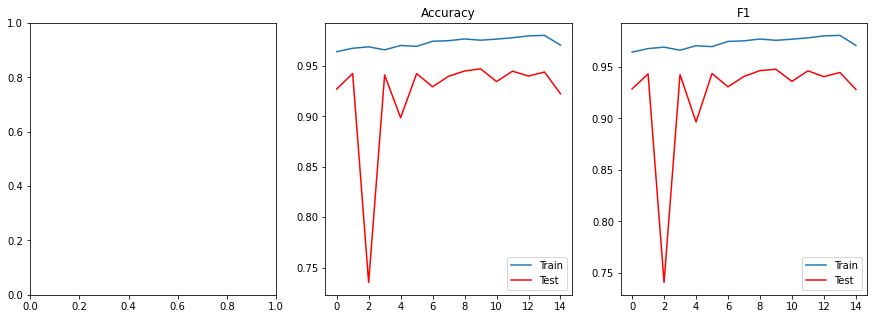

In [43]:
fig2, ax = plt.subplots(1,3,  figsize=(15,5))
ax[1].plot(train_acc)
ax[2].plot(train_F1)
ax[1].plot(test_acc,'-r')
ax[2].plot(test_F1,'-r')
ax[1].set_title('Accuracy')
ax[2].set_title('F1')
ax[1].legend(("Train", "Test"))
ax[2].legend(("Train", "Test"))
plt.show()